!!GRADER PLEASE DO NOT PRESS RUN ALL AS TRAINING WAS DONE WITH GPU. PLEASE SCROLL DOWN TO LOOK AT EACH CELL. IF YOU WISH TO RUN WE HAVE THE MODEL'S WEIGHTS SAVED AND THEY CAN BE RUN BELOW.!!

This cell can be run without gpu, it simply loads the data and defines the model.

In [ ]:
# !pip install optuna
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import torch.optim as optim

df = pd.read_csv('train.csv')

# Remove the label column from the DataFrame and store it separately
labels = df.pop('label')

# Print labels and features
print("Features DataFrame:")
print(df.head())
print("\nLabels Series:")
print(labels.head())

# Drop id column if it exists
if 'id' in df.columns:
    df = df.drop(columns=['id'])


# Create an 80/20 train/validation split with stratification
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.values, labels.values, test_size=0.2, random_state=42, stratify=labels if hasattr(labels, 'values') else None)

# We'll prepare tensors for train/val but create dataloaders inside the grid-search loop so batch_size can vary
import torch
from torch.utils.data import TensorDataset
# Convert numpy arrays to tensors (we'll reuse these to create dataloaders later)
features_train_tensor = torch.tensor(X_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(y_train, dtype=torch.long)
features_val_tensor = torch.tensor(X_val, dtype=torch.float32)
labels_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Print dataset sizes
print(f"\nNumber of training samples: {features_train_tensor.shape[0]}")
print(f"Number of validation samples: {features_val_tensor.shape[0]}")


# Neural Network Definition
import torch.nn as nn
import torch.nn.functional as F
class SimpleNN(nn.Module):
    # Default architecture with 3 hidden layers and dropout of 0.5
    def __init__(self, input_size, num_classes, hidden_sizes=(512,256,128), dropout=0.5):
        super(SimpleNN, self).__init__()
        layers = []
        in_features = input_size
        # Create hidden layers
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            # Add batch normalization, ReLU activation, and dropout
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = h
        # Output layer
        layers.append(nn.Linear(in_features, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Features DataFrame:
   id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1   1   0.000000   0.000000   0.000000   0.071982   0.000000   0.000000   
2   2   0.111111   0.000000   0.111111   0.000000   0.000000   0.111111   
3   3   0.000000   0.087039   0.000000   0.000000   0.000000   0.000000   
4   4   0.000000   0.000000   0.069673   0.000000   0.069673   0.000000   

   feature_6  feature_7  feature_8  ...  feature_490  feature_491  \
0   0.000000   0.000000   0.000000  ...          0.0     0.000000   
1   0.000000   0.071982   0.000000  ...          0.0     0.000000   
2   0.000000   0.111111   0.000000  ...          0.0     0.000000   
3   0.000000   0.000000   0.087039  ...          0.0     0.000000   
4   0.069673   0.000000   0.000000  ...          0.0     0.069673   

   feature_492  feature_493  feature_494  feature_495  feature_496  \
0     0.000000          0.0          0.0    

This cell can be run safely as it simply defines the training functions

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

input_size = features_train_tensor.shape[1]
num_classes = len(labels.unique())
print(f'device: {device}')

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Helper function for training a single epoch
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training loop
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        # Predictions
        pred = out.argmax(1)
        # Correct predictions
        correct += (pred == y).sum().item()
        # Total samples
        total += y.size(0)

    # Return average loss and accuracy for the epoch
    return total_loss / len(loader), correct / total

# Helper function for validation
def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    # Validation loop
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total

# Objective function for Optuna
def objective(trial):

    # -------------------------
    # Hyperparameters to search
    # -------------------------
    lr = trial.suggest_float("lr", 1e-7, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.8)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512, 1024])

    # hidden layer size ranges
    h1 = trial.suggest_int("h1", 100, 10000)
    h2 = trial.suggest_int("h2", 100, 10000)
    hidden_sizes = (h1, h2)

    # -------------------------
    # DataLoaders
    # -------------------------
    train_loader = DataLoader(
        TensorDataset(features_train_tensor, labels_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(features_val_tensor, labels_val_tensor),
        batch_size=batch_size
    )

    # -------------------------
    # Model + Optimizer
    # -------------------------
    model = SimpleNN(input_size, num_classes, hidden_sizes, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # LR decrease on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    # -------------------------
    # Train
    # -------------------------
    best_acc = 0
    patience = 15
    patience_counter = 0

    for epoch in range(80):  # Fewer epochs because Optuna will run many trials
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = validate(model, val_loader)
        scheduler.step(val_acc)

        trial.report(val_acc, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    return best_acc


device: cpu


Optuna hyperparameter search, TA PLEASE DO NOT RUN, SEARCH WAS DONE ON AN RTX 4090 OVERNIGHT.

In [ ]:
# Optuna study
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize the objective function using Optuna
study.optimize(objective, n_trials=60)

print("Best trial:", study.best_trial.params)

[I 2025-11-18 18:35:17,301] A new study created in memory with name: no-name-2c647c87-fb3e-4f78-a011-76a6fdc218f7
[I 2025-11-18 18:54:29,006] Trial 0 finished with value: 0.6596048869248765 and parameters: {'lr': 5.753773794117183e-06, 'weight_decay': 0.005061576888752304, 'dropout': 0.6123957592679836, 'batch_size': 128, 'h1': 8676, 'h2': 6051}. Best is trial 0 with value: 0.6596048869248765.
[I 2025-11-18 19:02:24,651] Trial 1 finished with value: 0.691924443289143 and parameters: {'lr': 0.00021242802137208872, 'weight_decay': 1.328944872286916e-08, 'dropout': 0.778936896513396, 'batch_size': 128, 'h1': 3112, 'h2': 5295}. Best is trial 1 with value: 0.691924443289143.
[I 2025-11-18 19:05:31,166] Trial 2 finished with value: 0.5483493631401092 and parameters: {'lr': 1.0707712109770766e-05, 'weight_decay': 5.589524205217922e-07, 'dropout': 0.5282970263056657, 'batch_size': 1024, 'h1': 7874, 'h2': 2076}. Best is trial 1 with value: 0.691924443289143.
[I 2025-11-18 19:17:11,882] Trial 3 

Best trial: {'lr': 0.0011097439170888368, 'weight_decay': 1.0957784483182323e-08, 'dropout': 0.11227445420242246, 'batch_size': 128, 'h1': 8393, 'h2': 7653}


Training model with params achieved from optuna. WILL TAKE ABOUT AN HOUR TO RUN ON COLAB T4 GPU, ON RTX 4090 IT TOOK AROUND 20 mins

In [ ]:
# Comment out the following line to use the best parameters from the study
# best_params = study.best_params

# hardcoded best parameters from the study
best_params = {'lr': 0.0011097439170888368, 'weight_decay': 1.0957784483182323e-08, 'dropout': 0.11227445420242246, 'batch_size': 128, 'h1': 8393, 'h2': 7653}
hidden_sizes = (best_params["h1"], best_params["h2"])

# Final training with best hyperparameters
model = SimpleNN(input_size, num_classes, hidden_sizes, best_params["dropout"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# LR decrease on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

batch_size = best_params["batch_size"]

# DataLoaders
train_loader = DataLoader(TensorDataset(features_train_tensor, labels_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(features_val_tensor, labels_val_tensor), batch_size=batch_size)

# Initialize loss and accuracy history
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

# Set training parameters
epochs = 200
patience = 15
patience_counter = 0
best_acc = 0

print("="*40)
print(f'Best model parameters:')
print(f'Hidden: ({best_params["h1"]}, {best_params["h2"]})')
print(f'Batch size: {best_params["batch_size"]}')
print(f'Learning rate: {best_params["lr"]}')
print(f'Weight decay: {best_params["weight_decay"]}')
print(f'Dropout: {best_params["dropout"]}')
print("="*40)

# Training loop with early stopping
for epoch in range(epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_acc = validate(model, val_loader)
    scheduler.step(va_acc)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc {tr_acc:.4f} | Val Acc {va_acc:.4f}")

    if va_acc > best_acc:
        best_acc = va_acc
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch: {epoch+1}. Best Val Acc: {best_acc:.4f}")
        break



Best model parameters:
Hidden: (8393, 7653)
Batch size: 128
Learning rate: 0.0011097439170888368
Weight decay: 1.0957784483182323e-08
Dropout: 0.11227445420242246
Epoch 1/200 | Train Acc 0.3762 | Val Acc 0.5004
Epoch 2/200 | Train Acc 0.6495 | Val Acc 0.5945
Epoch 3/200 | Train Acc 0.8633 | Val Acc 0.6557
Epoch 4/200 | Train Acc 0.9734 | Val Acc 0.6992
Epoch 5/200 | Train Acc 0.9946 | Val Acc 0.7260
Epoch 6/200 | Train Acc 0.9964 | Val Acc 0.7171
Epoch 7/200 | Train Acc 0.9952 | Val Acc 0.7211
Epoch 8/200 | Train Acc 0.9956 | Val Acc 0.7245
Epoch 9/200 | Train Acc 0.9975 | Val Acc 0.7403
Epoch 10/200 | Train Acc 0.9987 | Val Acc 0.7534
Epoch 11/200 | Train Acc 0.9994 | Val Acc 0.7542
Epoch 12/200 | Train Acc 0.9996 | Val Acc 0.7569
Epoch 13/200 | Train Acc 0.9996 | Val Acc 0.7643
Epoch 14/200 | Train Acc 0.9997 | Val Acc 0.7707
Epoch 15/200 | Train Acc 0.9997 | Val Acc 0.7734
Epoch 16/200 | Train Acc 0.9999 | Val Acc 0.7781
Epoch 17/200 | Train Acc 0.9999 | Val Acc 0.7767
Epoch 18/200 

Cannot be run without first training, please only proceed with training if you have a powerful gpu.

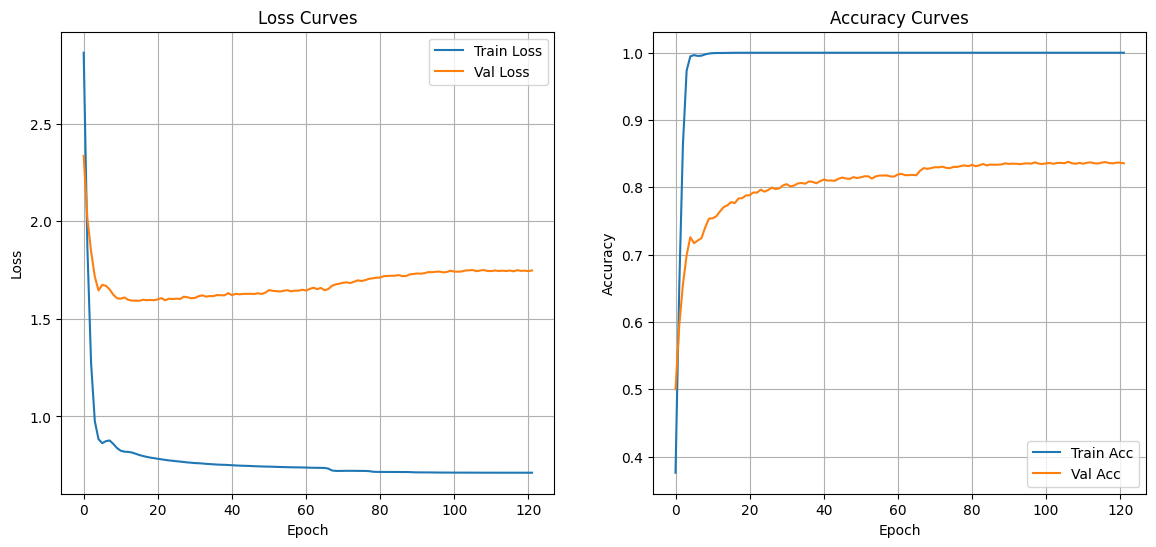

In [ ]:
# Plot training and validation curves

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()


Submission section, cannot be run at this point but will be executable in a later cell.

In [ ]:
# --------------------------
# LOAD TEST DATA
# --------------------------
test_df = pd.read_csv("test.csv")

if "id" in test_df.columns:
    test_ids = test_df["id"].values
    test_df = test_df.drop(columns=["id"])
else:
    raise ValueError("Test CSV missing 'id' column — required for submission.")

# Convert test features to tensors
test_features = torch.tensor(test_df.values, dtype=torch.float32)
test_dataset = TensorDataset(test_features)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# --------------------------
# GENERATE PREDICTIONS
# --------------------------
preds = []

model.eval()

# Prediction loop
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())

# --------------------------
# CREATE SUBMISSION FILE
# --------------------------
submission_df = pd.DataFrame({
    "id": test_ids,
    "label": preds
})
submission_df.to_csv("submission.csv", index=False)

print(f"\nPredictions saved to submission.csv")
print(f"Total predictions: {len(preds)}")
print(f"Unique classes predicted: {len(set(preds))} / {num_classes}")
print("="*60)


Sanity Check - Validation accuracy: 0.8357
Best validation accuracy from Optuna retraining: 0.8380
✓ Model validated successfully!

Predictions saved to submission.csv
Total predictions: 49460
Unique classes predicted: 50 / 50


Confustion matrix for model trained on gpu, once again do not run unless you've trained yourself

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# ---------------------------------------------------------
# ERROR ANALYSIS ON VALIDATION SET
# ---------------------------------------------------------
print("\n" + "="*60)
print("ERROR ANALYSIS ON VALIDATION DATA")
print("="*60)

# 1. Get predictions and true labels
with torch.no_grad():
    logits = model(features_val_tensor.to(device))
    _, preds = torch.max(logits, 1)

y_true = labels_val_tensor.cpu().numpy()
y_pred = preds.cpu().numpy()

# Classifcation report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
num_classes = cm.shape[0]

# 3. Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)


# 4. Most confused class pairs
print("\nMost Confused Class Pairs:")
confusions = []

for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 0:
            confusions.append((i, j, cm[i, j]))

confusions = sorted(confusions, key=lambda x: x[2], reverse=True)

for i, j, count in confusions[:5]:  # top 5 most confused
    print(f"True class {i} → Predicted class {j}: {count} times")

# 5. Strong classes (best performing)
sorted_classes = sorted(range(num_classes), key=lambda c: class_acc[c], reverse=True)
print("\nStrongest Classes (Highest Accuracy):")
for c in sorted_classes[:3]:  # top 3
    print(f"Class {c}: accuracy {class_acc[c]:.4f}")

# 6. Weak classes (worst performing)
print("\nWeakest Classes (Lowest Accuracy):")
for c in sorted_classes[-3:]:  # bottom 3
    print(f"Class {c}: accuracy {class_acc[c]:.4f}")


ERROR ANALYSIS ON VALIDATION DATA

Classification Report:
              precision    recall  f1-score   support

           0     0.8726    0.8009    0.8352       462
           1     0.8184    0.7918    0.8049       461
           2     0.8900    0.8069    0.8464       461
           3     0.8040    0.8701    0.8358       462
           4     0.8319    0.8247    0.8283       462
           5     0.9379    0.8831    0.9097       462
           6     0.7484    0.7727    0.7604       462
           7     0.7796    0.8134    0.7962       461
           8     0.8128    0.8004    0.8066       461
           9     0.8436    0.7121    0.7723       462
          10     0.8458    0.7614    0.8014       461
          11     0.8742    0.9197    0.8964       461
          12     0.8379    0.9177    0.8760       462
          13     0.9120    0.9199    0.9159       462
          14     0.8226    0.8351    0.8288       461
          15     0.7914    0.8413    0.8156       460
          16     0.820

Saving the model to output file

In [9]:
# Save the model
torch.save(model.state_dict(), "0.833_best_model.pth")

BELOW CELLS CAN BE RUN SAFELY ON ANY SYSTEM

Download model from Raagav Prasanna's Google Drive. Done because model is too big to push to GitHub

In [12]:
# download model from google drive
import gdown

url = "https://drive.google.com/file/d/1ZcH47efgoa_3ULUp1UMWyZ2TKqd-MJro/view?usp=sharing"
output = "0.833_best_model.pth"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1ZcH47efgoa_3ULUp1UMWyZ2TKqd-MJro
From (redirected): https://drive.google.com/uc?id=1ZcH47efgoa_3ULUp1UMWyZ2TKqd-MJro&confirm=t&uuid=1f7b0dfe-4d4a-4e4e-90b1-32c4e2381951
To: /home/raagav/Concordia/COMP432/new_dir/comp432-project/final_model/0.833_best_model.pth
100%|██████████| 276M/276M [00:25<00:00, 10.8MB/s] 


'0.833_best_model.pth'

In [ ]:
# Load model from pth file
state_dict = torch.load('0.833_best_model.pth', weights_only=True, map_location=device)

# Load on gpu if available
new_model = SimpleNN(input_size, num_classes, (8393,7653), 0.11227445420242246).to(device)
new_model.load_state_dict(state_dict)
new_model.eval()

SimpleNN(
  (net): Sequential(
    (0): Linear(in_features=500, out_features=8393, bias=True)
    (1): BatchNorm1d(8393, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.11227445420242246, inplace=False)
    (4): Linear(in_features=8393, out_features=7653, bias=True)
    (5): BatchNorm1d(7653, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.11227445420242246, inplace=False)
    (8): Linear(in_features=7653, out_features=50, bias=True)
  )
)

Run inference on validation data for sanity check

In [14]:
# Run inference on validation data
with torch.no_grad():
    logits = new_model(features_val_tensor.to(device))
    _, preds = torch.max(logits, 1)
    val_acc_check = (preds == labels_val_tensor.to(device)).float().mean().item()

print(f"\nSanity Check - Validation accuracy: {val_acc_check:.4f}")


Sanity Check - Validation accuracy: 0.8357


Run inference on test data and create alternative submissions file. Will take about 90 seconds to run on CPU, tested on Laptop Ryzen 7

In [8]:
# --------------------------
# LOAD TEST DATA
# --------------------------
test_df = pd.read_csv("test.csv")

if "id" in test_df.columns:
    test_ids = test_df["id"].values
    test_df = test_df.drop(columns=["id"])
else:
    raise ValueError("Test CSV missing 'id' column — required for submission.")

test_features = torch.tensor(test_df.values, dtype=torch.float32)
test_dataset = TensorDataset(test_features)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# --------------------------
# GENERATE PREDICTIONS
# --------------------------
preds = []

new_model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = new_model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())

# --------------------------
# CREATE SUBMISSION FILE
# --------------------------
submission_df = pd.DataFrame({
    "id": test_ids,
    "label": preds
})
submission_df.to_csv("submission_postload.csv", index=False)

print(f"\nPredictions saved to submission_postload.csv")
print(f"Total predictions: {len(preds)}")
print(f"Unique classes predicted: {len(set(preds))} / {num_classes}")
print("="*60)


Predictions saved to submission_postload.csv
Total predictions: 49460
Unique classes predicted: 50 / 50


Error analysis for loaded model

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

# ---------------------------------------------------------
# ERROR ANALYSIS ON VALIDATION SET
# ---------------------------------------------------------
print("\n" + "="*60)
print("ERROR ANALYSIS ON VALIDATION DATA")
print("="*60)

# 1. Get predictions and true labels
with torch.no_grad():
    logits = new_model(features_val_tensor.to(device))
    _, preds = torch.max(logits, 1)

y_true = labels_val_tensor.cpu().numpy()
y_pred = preds.cpu().numpy()

# Classifcation report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
num_classes = cm.shape[0]

# 3. Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)


# 4. Most confused class pairs
print("\nMost Confused Class Pairs:")
confusions = []

for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 0:
            confusions.append((i, j, cm[i, j]))

confusions = sorted(confusions, key=lambda x: x[2], reverse=True)

for i, j, count in confusions[:5]:  # top 5 most confused
    print(f"True class {i} → Predicted class {j}: {count} times")

# 5. Strong classes (best performing)
sorted_classes = sorted(range(num_classes), key=lambda c: class_acc[c], reverse=True)
print("\nStrongest Classes (Highest Accuracy):")
for c in sorted_classes[:3]:  # top 3
    print(f"Class {c}: accuracy {class_acc[c]:.4f}")

# 6. Weak classes (worst performing)
print("\nWeakest Classes (Lowest Accuracy):")
for c in sorted_classes[-3:]:  # bottom 3
    print(f"Class {c}: accuracy {class_acc[c]:.4f}")


ERROR ANALYSIS ON VALIDATION DATA

Classification Report:
              precision    recall  f1-score   support

           0     0.8726    0.8009    0.8352       462
           1     0.8184    0.7918    0.8049       461
           2     0.8900    0.8069    0.8464       461
           3     0.8040    0.8701    0.8358       462
           4     0.8319    0.8247    0.8283       462
           5     0.9379    0.8831    0.9097       462
           6     0.7484    0.7727    0.7604       462
           7     0.7796    0.8134    0.7962       461
           8     0.8128    0.8004    0.8066       461
           9     0.8436    0.7121    0.7723       462
          10     0.8458    0.7614    0.8014       461
          11     0.8742    0.9197    0.8964       461
          12     0.8379    0.9177    0.8760       462
          13     0.9120    0.9199    0.9159       462
          14     0.8226    0.8351    0.8288       461
          15     0.7914    0.8413    0.8156       460
          16     0.820